# Optimizing IT Support Team Performance Using Analytics
## Milestone 1: Data Preparation & Feature Engineering

This notebook documents the steps involved in loading, cleaning, and preparing customer support ticket data for performance analysis.



###Module 1: Project Initialization and Dataset Setup

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Clsutering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


## Dataset Overview

The dataset used in this project contains real-world customer support ticket records including ticket priority, response time, resolution time, and customer satisfaction ratings.


In [2]:
df = pd.read_csv("/content/customer_support_tickets.csv")
df.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,22-03-2021,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,01-06-2023 12:15,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,22-05-2021,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,01-06-2023 16:45,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,14-07-2020,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,01-06-2023 11:14,01-06-2023 18:05,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,13-11-2020,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,01-06-2023 07:29,01-06-2023 01:57,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,04-02-2020,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,01-06-2023 00:12,01-06-2023 19:53,1.0


In [3]:
df.shape
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

###Module 2: Data Cleaning and Feature Engineering

In [4]:
df.isnull().sum()


,0
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0


In [5]:
df['Ticket Priority'].value_counts()
df['Ticket Status'].value_counts()
df['Ticket Type'].value_counts()


,count
Ticket Type,
Refund request,1752
Technical issue,1747
Cancellation request,1695
Product inquiry,1641
Billing inquiry,1634


In [6]:
df = df.drop(columns=[
    'Customer Name',
    'Customer Email',
    'Customer Age',
    'Customer Gender'
])


## Datetime Processing

Timestamp columns are converted into datetime format to enable accurate calculation of resolution duration and other time-based performance metrics.


In [7]:
df['Time to Resolution'] = pd.to_datetime(
    df['Time to Resolution'],
    errors='coerce'
)

df['First Response Time'] = pd.to_datetime(
    df['First Response Time'],
    errors='coerce'
)

df[['First Response Time', 'Time to Resolution']].dtypes

df['Resolution_Duration_Hours'] = (
    df['Time to Resolution'] - df['First Response Time']
).dt.total_seconds() / 3600

df['Resolution_Duration_Hours'] = df['Resolution_Duration_Hours'].fillna(
    df['Resolution_Duration_Hours'].median()
)


In [8]:
df['First_Response_Duration_Hours'] = (
    df['First Response Time'] - df['First Response Time'].min()
).dt.total_seconds() / 3600

df['Resolution_Efficiency'] = (
    df['Resolution_Duration_Hours'] / df['First_Response_Duration_Hours']
)

df['Resolution_Efficiency'] = df['Resolution_Efficiency'].replace(
    [np.inf, -np.inf], np.nan
)

df['Resolution_Efficiency'] = df['Resolution_Efficiency'].fillna(
    df['Resolution_Efficiency'].median()
)


In [9]:
priority_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Critical': 4
}

df['Priority_Score'] = df['Ticket Priority'].map(priority_map)


In [10]:
df.isnull().sum()


,0
Ticket ID,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0
Ticket Status,0
Resolution,5700
Ticket Priority,0
Ticket Channel,0


## Feature Engineering and Final Output

New performance-related features such as resolution duration, resolution efficiency, and priority score were engineered. The cleaned dataset is saved for use in subsequent milestones.


In [11]:
df.to_csv("/content/cleaned_customer_support_tickets.csv", index=False)


# Milestone 2: Exploratory Visualization & Cluster Insights


## Module 3: Exploratory Data Analysis (EDA)


In [12]:
df.columns


Index(['Ticket ID', 'Product Purchased', 'Date of Purchase', 'Ticket Type',
       'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution',
       'Ticket Priority', 'Ticket Channel', 'First Response Time',
       'Time to Resolution', 'Customer Satisfaction Rating',
       'Resolution_Duration_Hours', 'First_Response_Duration_Hours',
       'Resolution_Efficiency', 'Priority_Score'],
      dtype='object')

In [13]:
df = pd.read_csv("/content/cleaned_customer_support_tickets.csv")


PLOT 1: Ticket Type Distribution



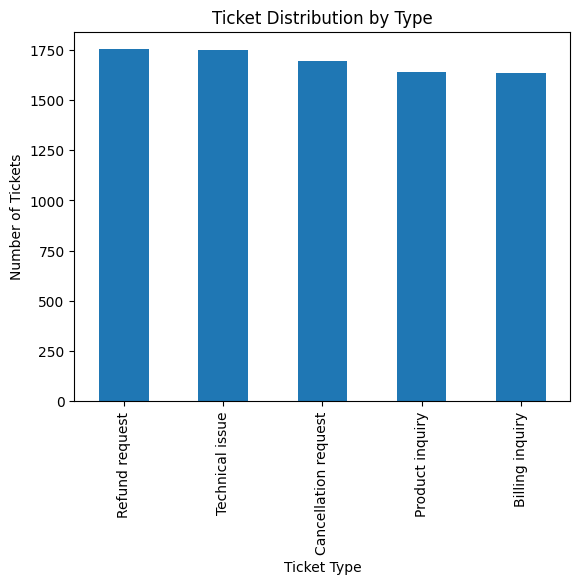

In [14]:
plt.figure()
df['Ticket Type'].value_counts().plot(kind='bar')
plt.title("Ticket Distribution by Type")
plt.xlabel("Ticket Type")
plt.ylabel("Number of Tickets")
plt.show()


PLOT 2: Ticket Priority Distribution





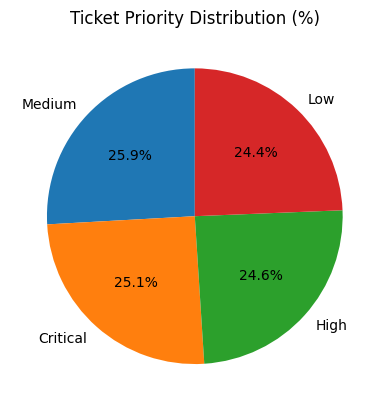

In [15]:
plt.figure()
df['Ticket Priority'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Ticket Priority Distribution (%)")
plt.ylabel("")   # removes default y-label
plt.show()



PLOT 3: Ticket Status Distribution

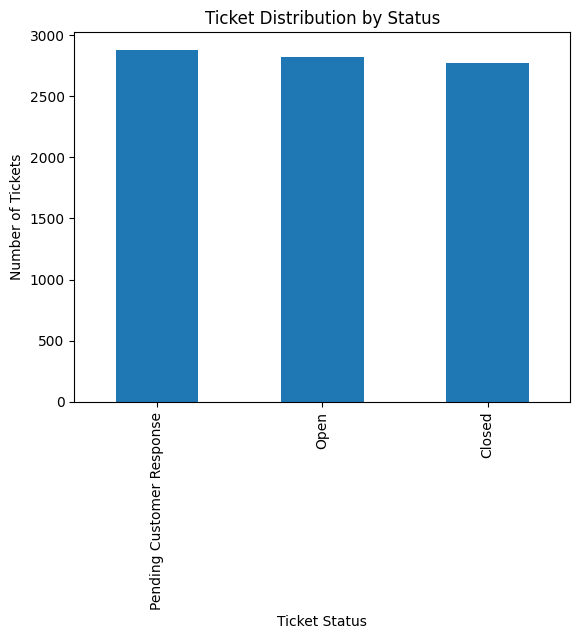

In [16]:
plt.figure()
df['Ticket Status'].value_counts().plot(kind='bar')
plt.title("Ticket Distribution by Status")
plt.xlabel("Ticket Status")
plt.ylabel("Number of Tickets")
plt.show()


PLOT 4: Ticket Channel Distribution

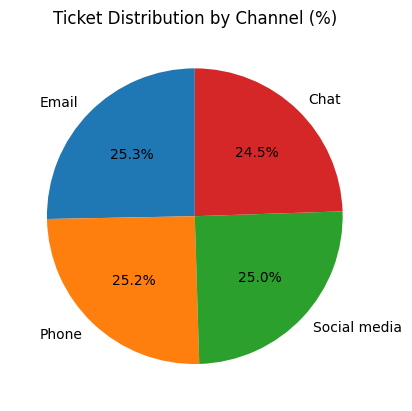

In [17]:
plt.figure()
df['Ticket Channel'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Ticket Distribution by Channel (%)")
plt.ylabel("")
plt.show()


PLOT 5: Top 10 Ticket Subjects

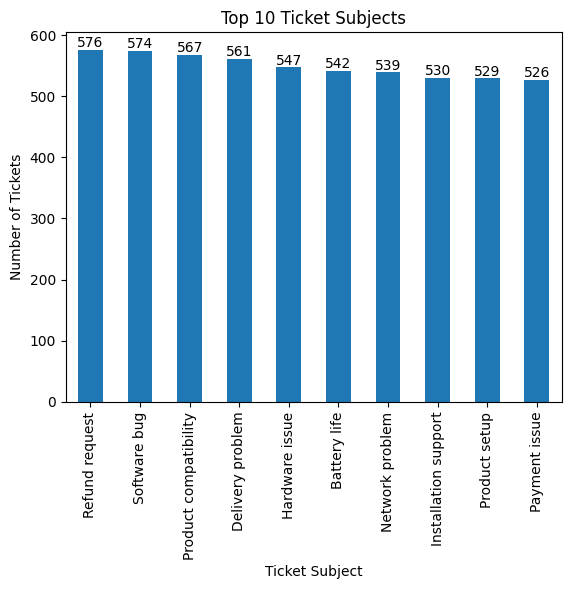

In [18]:
plt.figure()
ax = df['Ticket Subject'].value_counts().head(10).plot(kind='bar')

plt.title("Top 10 Ticket Subjects")
plt.xlabel("Ticket Subject")
plt.ylabel("Number of Tickets")

ax.bar_label(ax.containers[0])

plt.show()


PLOT 6: Resolution Duration Distribution

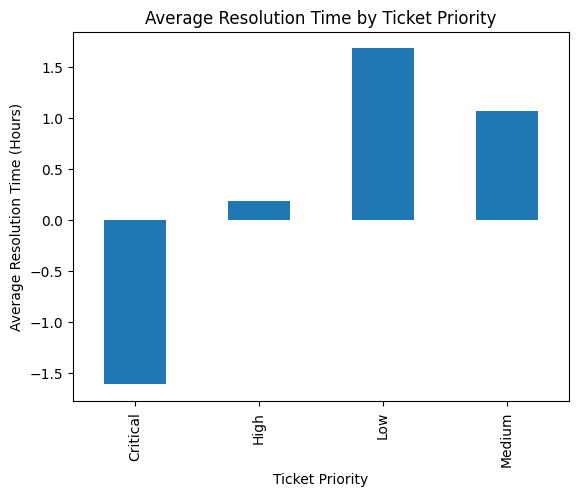

In [19]:
plt.figure()

avg_resolution = df.groupby('Ticket Priority')['Resolution_Duration_Hours'].mean()

avg_resolution.plot(kind='bar')

plt.title("Average Resolution Time by Ticket Priority")
plt.xlabel("Ticket Priority")
plt.ylabel("Average Resolution Time (Hours)")

plt.show()


PLOT 7: Customer Satisfaction Rating Distribution

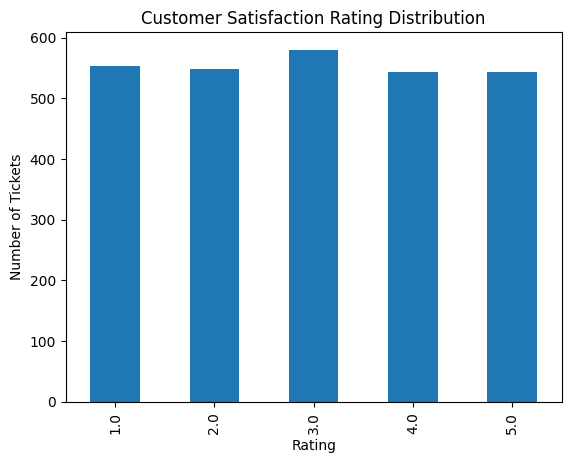

In [20]:
plt.figure()
df['Customer Satisfaction Rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Customer Satisfaction Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Tickets")
plt.show()


#Ticket Resolution Status

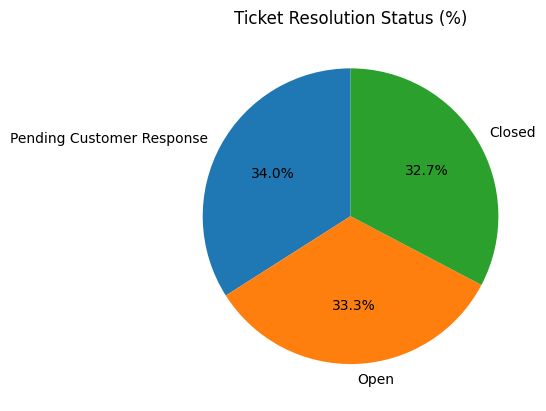

In [21]:
plt.figure()

df['Ticket Status'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Ticket Resolution Status (%)")
plt.ylabel("")
plt.show()


#Top Categories and Clusters by Frequency

Get top categories

In [22]:
top_categories = df['Ticket Subject'].value_counts().head(10)
top_categories


,count
Ticket Subject,
Refund request,576
Software bug,574
Product compatibility,567
Delivery problem,561
Hardware issue,547
Battery life,542
Network problem,539
Installation support,530
Product setup,529


Bar graph WITH exact numbers

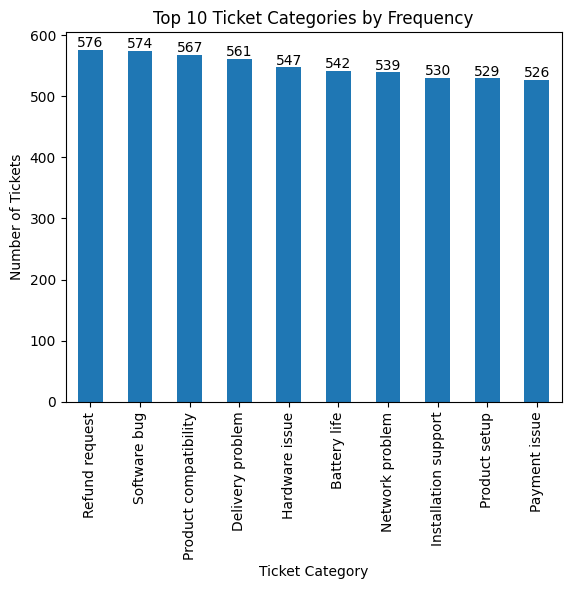

In [23]:
plt.figure()

ax = top_categories.plot(kind='bar')

plt.title("Top 10 Ticket Categories by Frequency")
plt.xlabel("Ticket Category")
plt.ylabel("Number of Tickets")

ax.bar_label(ax.containers[0])

plt.show()


#Visualizing Ticket by Priority and Channel

Verifying Columns

In [24]:
df[['Ticket Priority', 'Ticket Channel']].head()


,Ticket Priority,Ticket Channel
0,Critical,Social media
1,Critical,Chat
2,Low,Social media
3,Low,Social media
4,Low,Email


Plotting Ticket Priority vs Ticket Channel

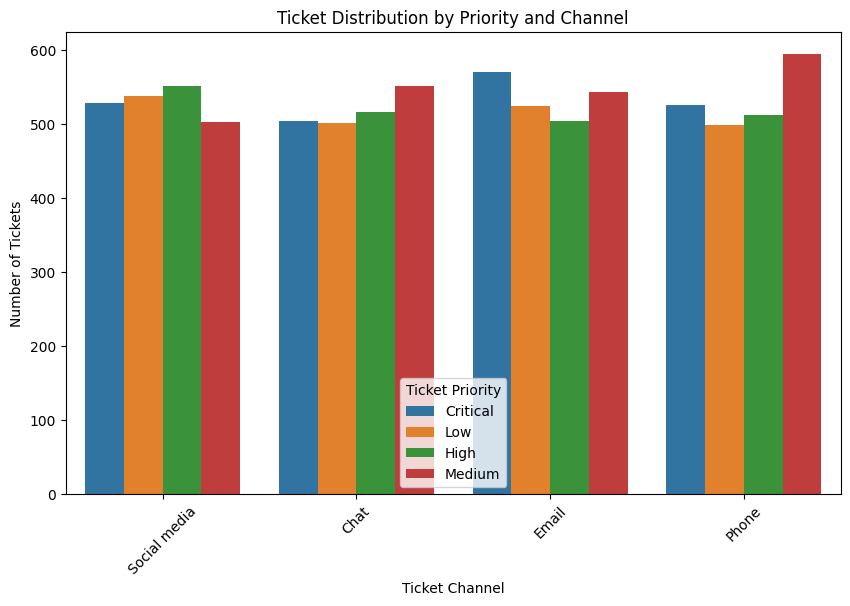

In [25]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='Ticket Channel',
    hue='Ticket Priority'
)

plt.title("Ticket Distribution by Priority and Channel")
plt.xlabel("Ticket Channel")
plt.ylabel("Number of Tickets")
plt.xticks(rotation=45)
plt.legend(title="Ticket Priority")

plt.show()


#Combining Ticket Subject + Description

In [26]:
df['Ticket_text'] = (
    df['Ticket Subject'].fillna('')+' '+
    df['Ticket Description'].fillna('')
)

Converting Text to Numbers

In [27]:
vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_features=500
)

X = vectorizer.fit_transform(df['Ticket_text'])

Create Clusters (Using KMeans)

In [28]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
df['Cluster_ID'] = kmeans.fit_predict(X)

In [29]:
df['Cluster_ID'].value_counts()


,count
Cluster_ID,
3,3587
1,2338
2,956
4,932
0,656


Identifying Top Clusters By Frequency

In [30]:
cluster_counts = df['Cluster_ID'].value_counts().sort_index()
cluster_counts


,count
Cluster_ID,
0,656
1,2338
2,956
3,3587
4,932


Visuals Top Cluster By Frquency

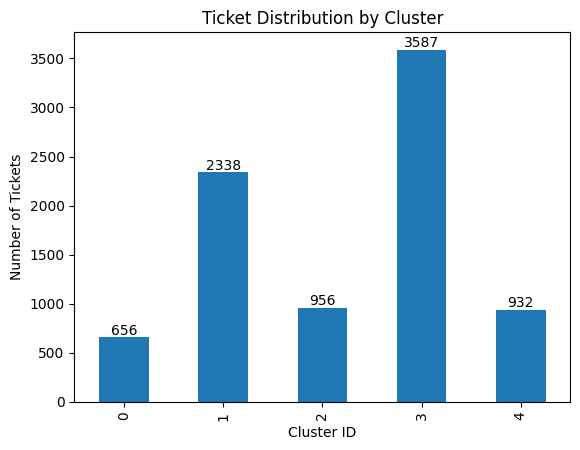

In [31]:
plt.figure()

ax = cluster_counts.plot(kind='bar')
plt.title("Ticket Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tickets")

ax.bar_label(ax.containers[0])
plt.show()


WHAT EACH CLUSTER REPRESENTS

In [32]:
df.groupby('Cluster_ID')['Ticket Subject'].head(3)


,Ticket Subject
0,Product setup
1,Peripheral compatibility
2,Network problem
3,Account access
4,Data loss
5,Payment issue
6,Refund request
7,Battery life
8,Installation support
9,Payment issue


Computing Similarity Scores

In [33]:
centroids = kmeans.cluster_centers_

similarity_matrix = cosine_similarity(X, centroids)

df['Similarity_Score'] = [
    similarity_matrix[i, cluster]
    for i, cluster in enumerate(df['Cluster_ID'])
]


#Analyze Similarity Scores within Clusters

Calculating Average Similarity

In [34]:
avg_similarity = df.groupby('Cluster_ID')['Similarity_Score'].mean()
avg_similarity


,Similarity_Score
Cluster_ID,
0,0.464732
1,0.369989
2,0.457770
3,0.318944
4,0.527199


Visuals of Average Similarity Scores

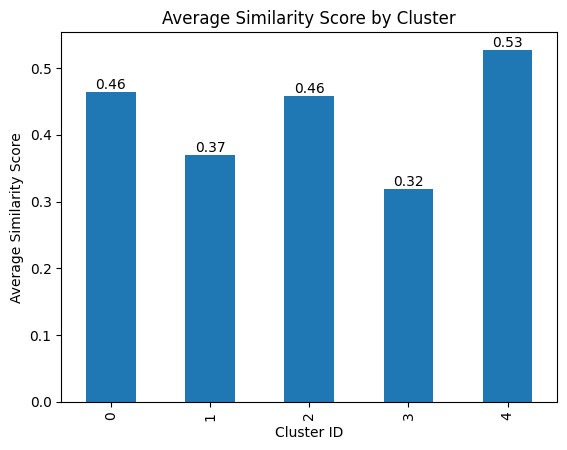

In [35]:
plt.figure()

ax = avg_similarity.plot(kind='bar')

plt.title("Average Similarity Score by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Average Similarity Score")

ax.bar_label(ax.containers[0], fmt="%.2f")
plt.show()


Average Resolution Time by Cluster

In [36]:
avg_resolution_cluster = df.groupby('Cluster_ID')['Resolution_Duration_Hours'].mean()
avg_resolution_cluster


,Resolution_Duration_Hours
Cluster_ID,
0,3.242683
1,-0.836477
2,1.237483
3,0.151617
4,0.892686


Visuals of Average Time Resolution by Cluster

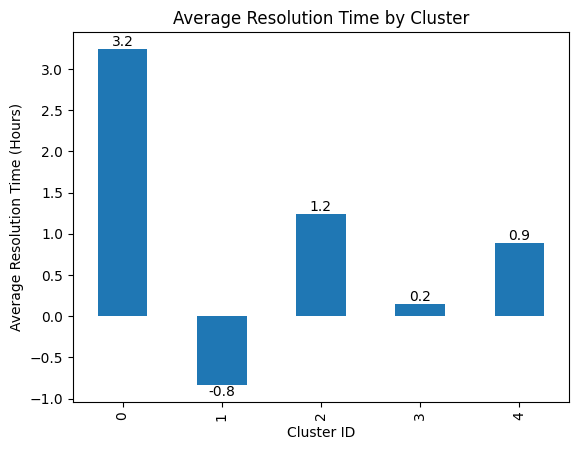

In [37]:
plt.figure()

ax = avg_resolution_cluster.plot(kind='bar')
plt.title("Average Resolution Time by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Average Resolution Time (Hours)")

ax.bar_label(ax.containers[0], fmt="%.1f")
plt.show()


#Compare Cluster Size VS. Issue Type

In [38]:
#Dfeining "Issue Type": The best Issue type is 'Ticket Subject' according to my dataset

Creating a Cluster and Issue Type Table

In [39]:
cluster_issue_counts = (
    df.groupby(['Cluster_ID', 'Ticket Subject']).size()
    .reset_index(name = 'Ticket_Count')
)

cluster_issue_counts.head()

,Cluster_ID,Ticket Subject,Ticket_Count
0,0,Account access,41
1,0,Battery life,40
2,0,Cancellation request,44
3,0,Data loss,43
4,0,Delivery problem,45


Identifying Top Isuue per Cluster

In [40]:
top_issue_per_cluster = (
    cluster_issue_counts.sort_values(['Cluster_ID', 'Ticket_Count'], ascending = [True, False])
    .groupby('Cluster_ID').head(1)
)

top_issue_per_cluster

,Cluster_ID,Ticket Subject,Ticket_Count
15,0,Software bug,49
29,1,Product setup,174
36,2,Delivery problem,72
62,3,Refund request,253
70,4,Hardware issue,76


Visuals of Cluster Size VS. Issue Type

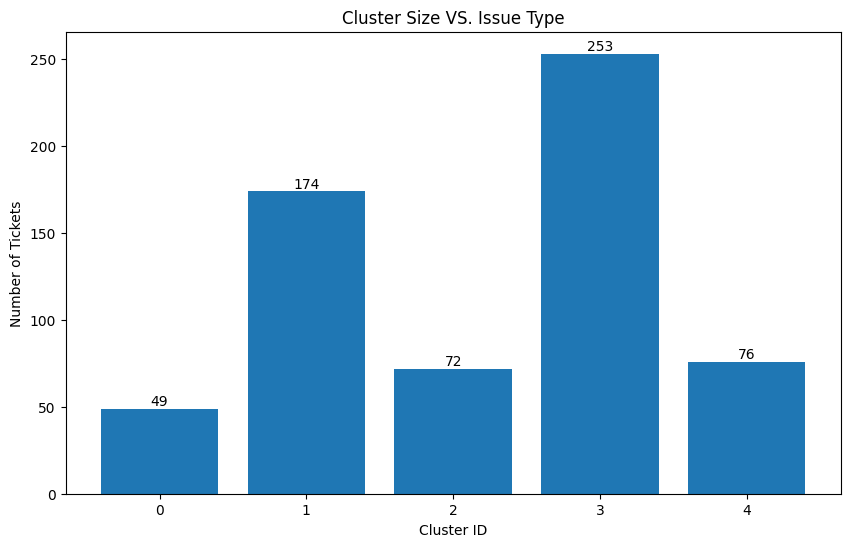

In [41]:
plt.figure(figsize = (10,6))

ax = plt.bar(
    top_issue_per_cluster['Cluster_ID'].astype(str),
    top_issue_per_cluster['Ticket_Count']
)

plt.title("Cluster Size VS. Issue Type")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tickets")

plt.bar_label(ax)

plt.show()

#Visualize performance gaps using boxplots and scatter plots

Plot 1 (Boxplot) : Resolution Time by Cluster

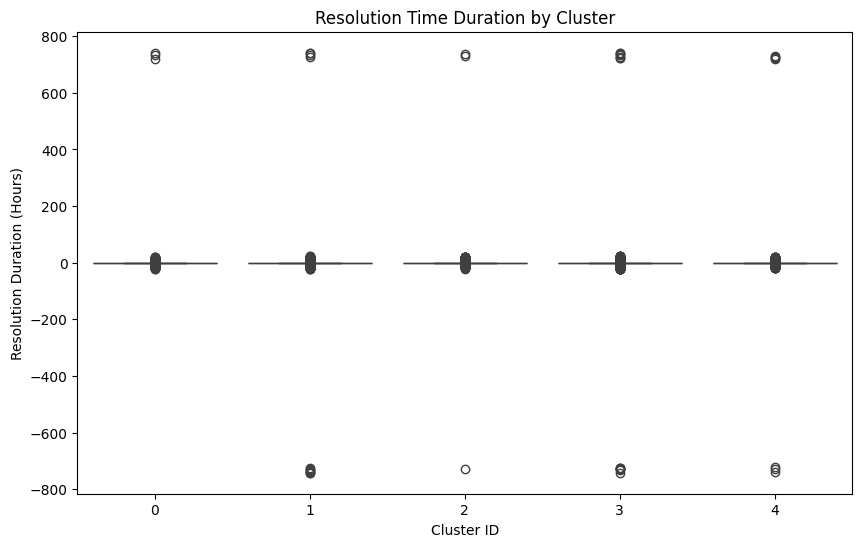

In [42]:
plt.figure(figsize=(10,6))

sns.boxplot(
    x = 'Cluster_ID',
    y = 'Resolution_Duration_Hours',
    data = df
)

plt.title("Resolution Time Duration by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Resolution Duration (Hours)")
plt.show()

Plot 2 (Boxplot): Customer Satisfaction Distribution by Cluster

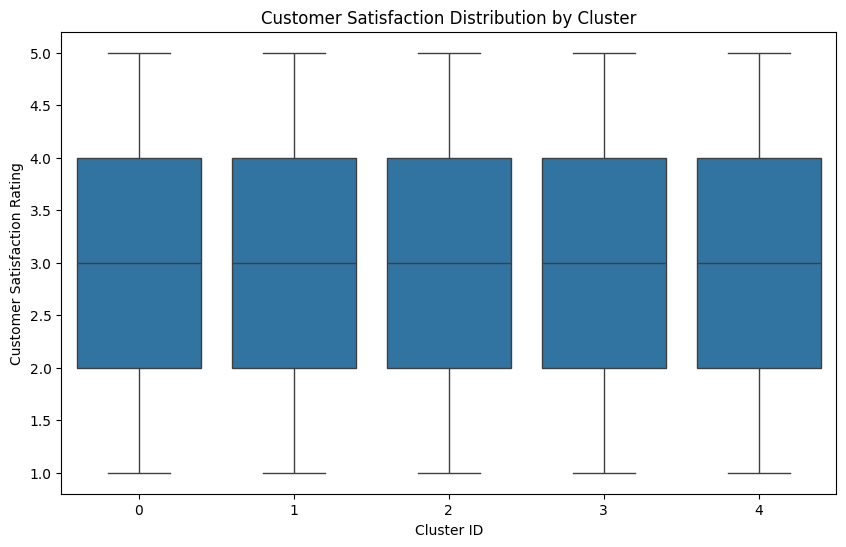

In [43]:
plt.figure(figsize = (10,6))

sns.boxplot(
    x = 'Cluster_ID',
    y = 'Customer Satisfaction Rating',
    data = df
)

plt.title("Customer Satisfaction Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Customer Satisfaction Rating")
plt.show()

Plot 3 (Scatter Plot): Similarity Score VS. Resolution Time

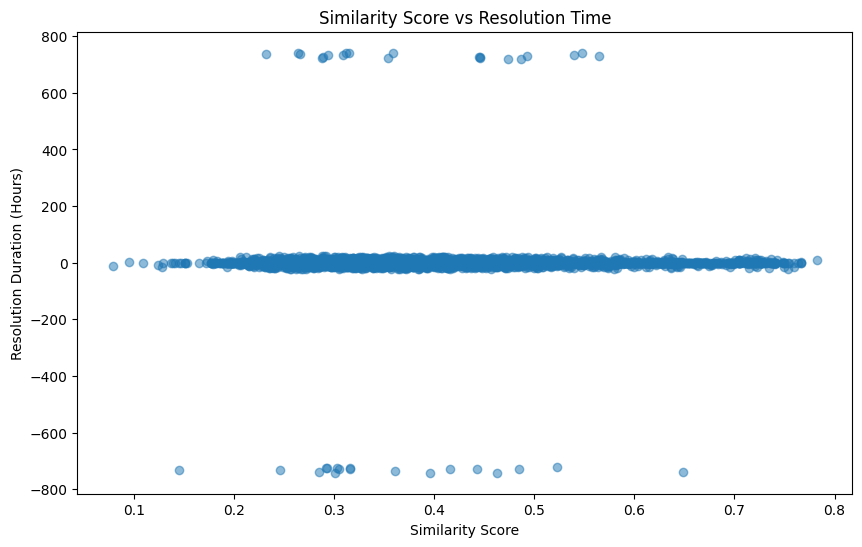

In [44]:
plt.figure(figsize = (10,6))

plt.scatter(
    df['Similarity_Score'],
    df['Resolution_Duration_Hours'],
    alpha = 0.5
)

plt.title("Similarity Score vs Resolution Time")
plt.xlabel("Similarity Score")
plt.ylabel("Resolution Duration (Hours)")
plt.show()

Plot 4 (Scatter Plot): Resolution Time VS. Customer Satisfaction

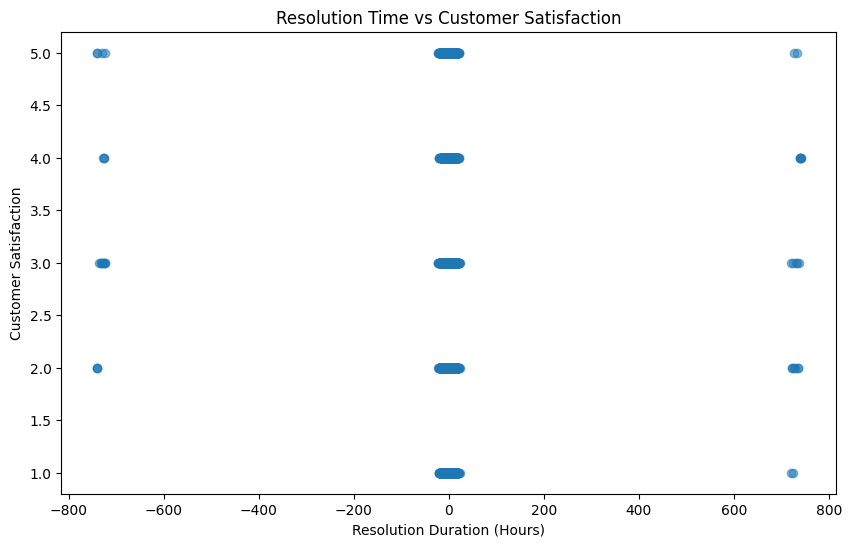

In [45]:
plt.figure(figsize = (10,6))

plt.scatter(
    df['Resolution_Duration_Hours'],
    df['Customer Satisfaction Rating'],
    alpha = 0.5
)

plt.title("Resolution Time vs Customer Satisfaction")
plt.xlabel("Resolution Duration (Hours)")
plt.ylabel("Customer Satisfaction")
plt.show()